# How to train your own word vector embeddings using Gensim

Many tasks require embeddings or domain-specific vocabulary that pre-trained models based on a generic corpus may not represent well or at all. Standard word2vec models are not able to assign vectors to out-of-vocabulary words and instead use a default vector that reduces their predictive value.

E.g., when working with industry-specific documents, the vocabulary or its usage may change over time as new technologies or products emerge. As a result, the embeddings need to evolve as well. In addition, corporate earnings releases use nuanced language not fully reflected in Glove vectors pre-trained on Wikipedia articles.

In this notebook we illustrate the more performant gensim adaptation of the code provided by the word2vec authors. 

To illustrate the word2vec network architecture, we use the Financial News data that we first introduced in chapter 14 on Topic Modeling. 

## Data

<div style='direction:rtl; font-family: "B Nazanin"; font-size: 20px;'> 
در این بخش از داده‌های پیش‌پردازش شده در نوت بوک شماره ۳ (03_financial_news_preprocessing_julia.ipynb) استفاده شده است.
بنابراین لازم است که ابتدا آن نوت بوک اجرا شود.

## Imports

In [47]:
using Pkg

In [48]:
using PyCall
using Conda

In [49]:
#Pkg.add("Glob")
#Pkg.add("TextAnalysis")
#Pkg.add("DataFrames")
#Pkg.add("Plots")
#Pkg.add("CSV")
#Pkg.add("JSON")
#Pkg.add("StatsBase")

In [50]:
using Glob
using DataFrames
using Plots
using Printf
using CSV
using StatsBase

In [51]:
#Conda.add("gensim")
@pyimport gensim

In [52]:
Word2Vec = gensim.models.Word2Vec
KeyedVectors = gensim.models.KeyedVectors
LineSentence = gensim.models.word2vec.LineSentence

PyObject <class 'gensim.models.word2vec.LineSentence'>

In [53]:
using ScikitLearn
using ScikitLearn: @sk_import

In [54]:
@sk_import decomposition: IncrementalPCA

PyObject <class 'sklearn.decomposition._incremental_pca.IncrementalPCA'>

### Paths

In [55]:
news_path = joinpath("data", "fin_news")
data_path = joinpath(news_path, "data")
analogy_path = joinpath("data", "analogies-en.txt")

"data\\analogies-en.txt"

In [56]:
function format_time(t)
    m = t ÷ 60
    s = t % 60
    h = m ÷ 60
    m = m % 60
    h = length("$h") == 2 ? h : "0$h"
    m = length("$m") == 2 ? m : "0$m"
    s = length("$s") == 2 ? s : "0$s"
    return "$h:$m:$s"
end

format_time (generic function with 1 method)

## Model Configuration

In [57]:
gensim_path = joinpath(news_path, "gensim")
if !(isdir(gensim_path))
    mkpath(gensim_path)
end

In [58]:
NGRAMS = 3           # Longest ngram in text
MIN_FREQ = 100
WINDOW_SIZE = 5
EMBEDDING_SIZE = 300
NEGATIVE_SAMPLES = 20
EPOCHS = 1

1

In [59]:
FILE_NAME = "articles_$(NGRAMS)_grams.txt"

"articles_3_grams.txt"

## Sentence Generator

In [60]:
sentence_path = joinpath(data_path, FILE_NAME)
sentences = LineSentence(sentence_path)

PyObject <gensim.models.word2vec.LineSentence object at 0x0000000083D7DF10>

## Train word2vec Model

In [61]:
start_time = time()
model = Word2Vec(sentences, 
                 sg=1, # set to 1 for skipgram; CBOW otherwise
                 vector_size=EMBEDDING_SIZE, 
                 window=WINDOW_SIZE,
                 min_count=MIN_FREQ, 
                 negative=NEGATIVE_SAMPLES, 
                 workers=8,
                 epochs=EPOCHS, 
                 alpha=0.05)

# persist model
model.save(joinpath(gensim_path, "word2vec.model"))

# persist word vectors
model.wv.save(joinpath(gensim_path, "word_vectors.bin"))

end_time = time()
println("Duration: ", format_time(floor(Int64, end_time - start_time)))

Duration: 00:01:21


## Evaluate results

In [62]:
cat_dict = Dict("capital-common-countries" => "Capitals",
            "capital-world" => "Capitals RoW",
            "city-in-state" => "City-State",
            "currency" => "Currency",
            "family" => "Famliy",
            "gram1-adjective-to-adverb" => "Adj-Adverb",
            "gram2-opposite" => "Opposite",
            "gram3-comparative" => "Comparative",
            "gram4-superlative" => "Superlative",
            "gram5-present-participle" => "Pres. Part.",
            "gram6-nationality-adjective" => "Nationality",
            "gram7-past-tense" => "Past Tense",
            "gram8-plural" => "Plural",
            "gram9-plural-verbs" => "Plural Verbs",
            "total" => "Total")

Dict{String, String} with 15 entries:
  "capital-common-countries"    => "Capitals"
  "gram5-present-participle"    => "Pres. Part."
  "family"                      => "Famliy"
  "gram7-past-tense"            => "Past Tense"
  "gram8-plural"                => "Plural"
  "gram2-opposite"              => "Opposite"
  "total"                       => "Total"
  "city-in-state"               => "City-State"
  "gram3-comparative"           => "Comparative"
  "gram1-adjective-to-adverb"   => "Adj-Adverb"
  "gram4-superlative"           => "Superlative"
  "gram6-nationality-adjective" => "Nationality"
  "currency"                    => "Currency"
  "capital-world"               => "Capitals RoW"
  "gram9-plural-verbs"          => "Plural Verbs"

In [63]:
function accuracy_by_category(acc; detail=true)
    results = [[c["section"], length(c["correct"]), length(c["incorrect"])] for c ∈ acc]
    results = DataFrame(category=[result[1] for result in results], 
                        correct=[result[2] for result ∈ results], 
                        incorrect=[result[3] for result ∈ results])
            
    results[!, "average"] = results.correct./sum.(eachrow(results[:, ["correct", "incorrect"]]))
    if detail
        println(sort(results, :average, rev=true))
    end
    return convert(Array, filter(:category => ==("Total accuracy"), results))[2:end]
end

accuracy_by_category (generic function with 1 method)

In [64]:
# gensim computes accuracy based on source text files
detailed_accuracy = model.wv.evaluate_word_analogies(normpath(analogy_path), case_insensitive=true)[2]

15-element Vector{Dict{Any, Any}}:
 Dict("incorrect" => [("BAGHDAD", "IRAQ", "BANGKOK", "THAILAND"), ("BAGHDAD", "IRAQ", "BEIJING", "CHINA"), ("BAGHDAD", "IRAQ", "CAIRO", "EGYPT"), ("BAGHDAD", "IRAQ", "HAVANA", "CUBA"), ("BAGHDAD", "IRAQ", "ISLAMABAD", "PAKISTAN"), ("BAGHDAD", "IRAQ", "KABUL", "AFGHANISTAN"), ("BAGHDAD", "IRAQ", "LONDON", "ENGLAND"), ("BAGHDAD", "IRAQ", "MADRID", "SPAIN"), ("BAGHDAD", "IRAQ", "MOSCOW", "RUSSIA"), ("BAGHDAD", "IRAQ", "OTTAWA", "CANADA")  …  ("TOKYO", "JAPAN", "BERLIN", "GERMANY"), ("TOKYO", "JAPAN", "CAIRO", "EGYPT"), ("TOKYO", "JAPAN", "KABUL", "AFGHANISTAN"), ("TOKYO", "JAPAN", "LONDON", "ENGLAND"), ("TOKYO", "JAPAN", "MADRID", "SPAIN"), ("TOKYO", "JAPAN", "MOSCOW", "RUSSIA"), ("TOKYO", "JAPAN", "OTTAWA", "CANADA"), ("TOKYO", "JAPAN", "PARIS", "FRANCE"), ("TOKYO", "JAPAN", "ROME", "ITALY"), ("TOKYO", "JAPAN", "TEHRAN", "IRAN")], "correct" => [("BAGHDAD", "IRAQ", "BERLIN", "GERMANY"), ("BAGHDAD", "IRAQ", "OSLO", "NORWAY"), ("BANGKOK", "THAILAND", "BERL

In [65]:
# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
println("\nBase Accuracy: Correct $(summary[1]) | Wrong $(summary[2]) | Avg $(summary[3])")

15×4 DataFrame
│ Row │ category                    │ correct │ incorrect │ average    │
│     │ String                      │ Int64   │ Int64     │ Float64    │
├─────┼─────────────────────────────┼─────────┼───────────┼────────────┤
│ 1   │ capital-world               │ 36      │ 96        │ 0.272727   │
│ 2   │ city-in-state               │ 128     │ 454       │ 0.219931   │
│ 3   │ capital-common-countries    │ 58      │ 214       │ 0.213235   │
│ 4   │ gram6-nationality-adjective │ 57      │ 495       │ 0.103261   │
│ 5   │ gram2-opposite              │ 4       │ 38        │ 0.0952381  │
│ 6   │ Total accuracy              │ 305     │ 3803      │ 0.0742454  │
│ 7   │ family                      │ 3       │ 39        │ 0.0714286  │
│ 8   │ currency                    │ 2       │ 66        │ 0.0294118  │
│ 9   │ gram4-superlative           │ 5       │ 177       │ 0.0274725  │
│ 10  │ gram5-present-participle    │ 5       │ 415       │ 0.0119048  │
│ 11  │ gram9-plural-verbs          

In [66]:
most_sim = model.wv.most_similar(positive=["woman", "king"], negative=["man"], topn=20)
most_sim_df = DataFrame(token=[pair[1] for pair ∈ most_sim], 
                        similarity=[pair[2] for pair ∈ most_sim])

,token,similarity
,String,Float64
1,larry,0.373267
2,abdullah,0.364988
3,governors,0.336094
4,northeastern,0.325525
5,montana,0.32498
6,colorado,0.310465
7,buddhist,0.308163
8,entrance,0.307145
9,salman,0.306679


In [67]:
counter = Dict()
open(sentence_path, "r") do file
    for line ∈ readlines(file)
        addcounts!(counter, split(line))
    end
end
counter = sort(collect(counter), by=x->x[2], rev=true)

43285-element Vector{Pair{Any, Any}}:
         "said" => 62486
      "company" => 42908
         "year" => 31432
      "percent" => 31189
          "new" => 30009
      "reuters" => 29705
    "president" => 19066
       "market" => 18433
    "financial" => 18110
     "business" => 18043
      "million" => 17564
        "trump" => 15805
    "including" => 14762
                ⋮
       "donato" => 1
 "unassumingly" => 1
     "grieving" => 1
    "hindrance" => 1
   "culbertson" => 1
       "sahara" => 1
  "calibrating" => 1
    "socialism" => 1
   "shortlived" => 1
    "biovitrum" => 1
    "punctured" => 1
       "paltry" => 1

In [68]:
most_common = DataFrame(token = [pair[1] for pair in counter], count=[pair[2] for pair in counter])
most_common = filter(row -> row.count > MIN_FREQ, most_common)
most_common[!, "p"] = log.(most_common["count"])./sum(log.(most_common["count"]))
most_common

,token,count,p
,SubStri…,Int64,Float64
1,said,62486,0.000252494
2,company,42908,0.000243899
3,year,31432,0.000236783
4,percent,31189,0.000236605
5,new,30009,0.000235723
6,reuters,29705,0.000235491
7,president,19066,0.000225352
8,market,18433,0.00022458
9,financial,18110,0.000224176


In [69]:
similars = DataFrame()
for token in StatsBase.sample(most_common.token, Weights(most_common.p), 10)
    similars[token] = [s[1] for s ∈ model.wv.most_similar(token)]
end
DataFrame([[names(similars)]; collect.(eachrow(similars))], [:token; Symbol.(axes(similars, 1))])

,token,1,2,3,4,5
,String,String,String,String,String,String
1,pennsylvania,connecticut,counties,pittsburgh,eaton,birmingham
2,table,inflows,shy,restricting,reconciliation,unaudited
3,dropped,dipped,kuwait,sub,fallen,lowest
4,platforms,livexlive,telehealth,deluxe,platform,maven
5,sri,rupee,exporters,aditya,dealers,caroline
6,shutting,halted,threw,arriving,cynthia,rcom
7,smallest,echo,weakest,climbing,mini,tumbled
8,banks,dealers,bank,sri,syndicated,merchants
9,traction,federation,sangoma,kindred,innate,inter


## Continue Training

In [70]:
accuracies = [summary]
best_accuracy = summary[end]
for i ∈ 1:9
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    detailed_accuracy = model.wv.evaluate_word_analogies(analogy_path)[2]
    push!(accuracies, accuracy_by_category(detailed_accuracy; detail=false))
    
    println("$(i) | Duration: $(format_time(floor(Int, time() - start))) | Accuracy: $(accuracies[end][end]) ")
    
    if accuracies[end][end] > best_accuracy
        model.save(joinpath(gensim_path, "word2vec_$(i).model"))
        model.wv.save(joinpath(gensim_path, "word_vectors_$(i).bin"))
        best_accuracy = accuracies[end][end]
    end
    
    accuracy_df = DataFrame(correct = [accuracy[1] for accuracy in accuracies],
                            wrong = [accuracy[2] for accuracy ∈ accuracies], 
                            average = [accuracy[3] for accuracy ∈ accuracies])
    CSV.write(joinpath(gensim_path, "accuracies.csv"), accuracy_df)
end
model.wv.save(joinpath(gensim_path, "word_vectors_final.bin"))

1 | Duration: 00:01:41 | Accuracy: 0.11368062317429406 
2 | Duration: 00:01:09 | Accuracy: 0.10954235637779941 
3 | Duration: 00:01:08 | Accuracy: 0.12512171372930866 
4 | Duration: 00:01:20 | Accuracy: 0.11952288218111003 
5 | Duration: 00:01:55 | Accuracy: 0.13193768257059396 
6 | Duration: 00:01:59 | Accuracy: 0.14216163583252192 
7 | Duration: 00:01:33 | Accuracy: 0.1414313534566699 
8 | Duration: 00:01:28 | Accuracy: 0.1360759493670886 
9 | Duration: 00:01:32 | Accuracy: 0.13096397273612465 


## Evaluate Best Model

In [71]:
accuracies_df = DataFrame(correct = [accuracy[1] for accuracy ∈ accuracies], 
                            wrong = [accuracy[2] for accuracy ∈ accuracies], 
                            average = [accuracy[3] for accuracy ∈ accuracies])

#pd.DataFrame(accuracies, columns=["correct", "wrong", "average"], index=list(range(1, len(accuracies) + 1))).average.plot();

In [72]:
best_model = Word2Vec.load(normpath(joinpath(gensim_path, "word2vec_8.model")))

PyObject <gensim.models.word2vec.Word2Vec object at 0x000000008427D700>

In [73]:
# gensim computes accuracy based on source text files
detailed_accuracy = best_model.wv.evaluate_word_analogies(normpath(analogy_path), case_insensitive=true)[2]

15-element Vector{Dict{Any, Any}}:
 Dict("incorrect" => [("BAGHDAD", "IRAQ", "BANGKOK", "THAILAND"), ("BAGHDAD", "IRAQ", "CAIRO", "EGYPT"), ("BAGHDAD", "IRAQ", "ISLAMABAD", "PAKISTAN"), ("BAGHDAD", "IRAQ", "KABUL", "AFGHANISTAN"), ("BAGHDAD", "IRAQ", "LONDON", "ENGLAND"), ("BAGHDAD", "IRAQ", "MADRID", "SPAIN"), ("BAGHDAD", "IRAQ", "MOSCOW", "RUSSIA"), ("BAGHDAD", "IRAQ", "OTTAWA", "CANADA"), ("BAGHDAD", "IRAQ", "PARIS", "FRANCE"), ("BAGHDAD", "IRAQ", "ROME", "ITALY")  …  ("TOKYO", "JAPAN", "BAGHDAD", "IRAQ"), ("TOKYO", "JAPAN", "BANGKOK", "THAILAND"), ("TOKYO", "JAPAN", "ISLAMABAD", "PAKISTAN"), ("TOKYO", "JAPAN", "KABUL", "AFGHANISTAN"), ("TOKYO", "JAPAN", "LONDON", "ENGLAND"), ("TOKYO", "JAPAN", "MADRID", "SPAIN"), ("TOKYO", "JAPAN", "OTTAWA", "CANADA"), ("TOKYO", "JAPAN", "PARIS", "FRANCE"), ("TOKYO", "JAPAN", "ROME", "ITALY"), ("TOKYO", "JAPAN", "TEHRAN", "IRAN")], "correct" => [("BAGHDAD", "IRAQ", "BEIJING", "CHINA"), ("BAGHDAD", "IRAQ", "BERLIN", "GERMANY"), ("BAGHDAD", "IRAQ", "

In [74]:
# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
println("\nBase Accuracy: Correct $(summary[1]) | Wrong $(summary[2]) | Avg $(summary[3])")

15×4 DataFrame
│ Row │ category                    │ correct │ incorrect │ average    │
│     │ String                      │ Int64   │ Int64     │ Float64    │
├─────┼─────────────────────────────┼─────────┼───────────┼────────────┤
│ 1   │ capital-world               │ 74      │ 58        │ 0.560606   │
│ 2   │ city-in-state               │ 275     │ 307       │ 0.472509   │
│ 3   │ capital-common-countries    │ 100     │ 172       │ 0.367647   │
│ 4   │ gram6-nationality-adjective │ 87      │ 465       │ 0.157609   │
│ 5   │ Total accuracy              │ 559     │ 3549      │ 0.136076   │
│ 6   │ currency                    │ 5       │ 63        │ 0.0735294  │
│ 7   │ gram2-opposite              │ 3       │ 39        │ 0.0714286  │
│ 8   │ family                      │ 2       │ 40        │ 0.047619   │
│ 9   │ gram5-present-participle    │ 4       │ 416       │ 0.00952381 │
│ 10  │ gram7-past-tense            │ 6       │ 644       │ 0.00923077 │
│ 11  │ gram1-adjective-to-adverb   

In [75]:
results = [[c["section"], length(c["correct"]), length(c["incorrect"])] for c ∈ detailed_accuracy]

results = DataFrame(category = [result[1] for result ∈ results],
                    correct = [result[2] for result ∈ results], 
                    incorrect = [result[3] for result ∈ results])

for item ∈ keys(cat_dict)
    replace!(results[!, "category"], item => cat_dict[item])
end

results[!, "average"] = results.correct./sum.(eachrow(results[:, ["correct", "incorrect"]]))
rename!(results, uppercasefirst.(names(results)))
total = filter(row -> row.Category == "Total accuracy", results)
results = filter(row -> row.Category != "Total accuracy", results)
println(results)
println("\n Total: $(total)")

14×4 DataFrame
│ Row │ Category     │ Correct │ Incorrect │ Average    │
│     │ String       │ Int64   │ Int64     │ Float64    │
├─────┼──────────────┼─────────┼───────────┼────────────┤
│ 1   │ Capitals     │ 100     │ 172       │ 0.367647   │
│ 2   │ Capitals RoW │ 74      │ 58        │ 0.560606   │
│ 3   │ City-State   │ 275     │ 307       │ 0.472509   │
│ 4   │ Currency     │ 5       │ 63        │ 0.0735294  │
│ 5   │ Famliy       │ 2       │ 40        │ 0.047619   │
│ 6   │ Adj-Adverb   │ 1       │ 209       │ 0.0047619  │
│ 7   │ Opposite     │ 3       │ 39        │ 0.0714286  │
│ 8   │ Comparative  │ 1       │ 551       │ 0.00181159 │
│ 9   │ Superlative  │ 0       │ 182       │ 0.0        │
│ 10  │ Pres. Part.  │ 4       │ 416       │ 0.00952381 │
│ 11  │ Nationality  │ 87      │ 465       │ 0.157609   │
│ 12  │ Past Tense   │ 6       │ 644       │ 0.00923077 │
│ 13  │ Plural       │ 0       │ 132       │ 0.0        │
│ 14  │ Plural Verbs │ 1       │ 271       │ 0.00367647 │

In [76]:
most_sim = best_model.wv.most_similar(positive=["woman", "king"], negative=["man"], topn=20)
most_sim_df = DataFrame(token=[pair[1] for pair ∈ most_sim], 
                        similarity=[pair[2] for pair ∈ most_sim])

,token,similarity
,String,Float64
1,explained,0.265076
2,shore,0.264277
3,larry,0.257435
4,northeastern,0.249419
5,multifamily,0.246019
6,stonestreet,0.244861
7,gulf,0.242987
8,youngest,0.240385
9,relieved,0.236642


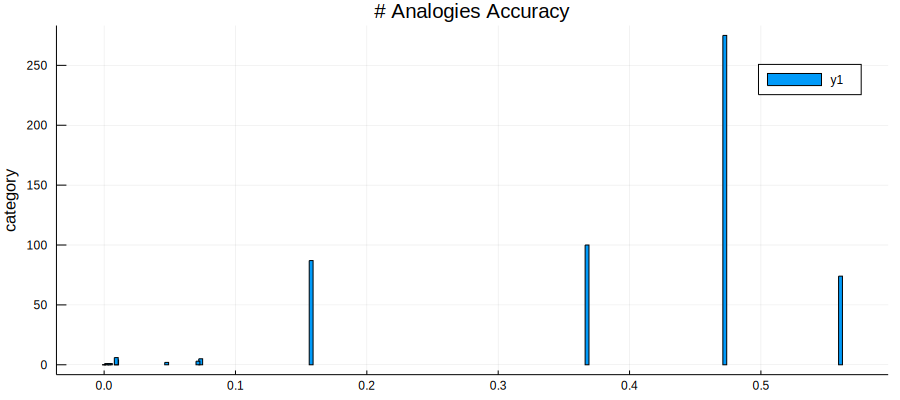

In [86]:
bar(results[:Average], results["Correct"])
plot!(size=(900, 400))
ylabel!("Correct")
title!("# Analogies Accuracy")

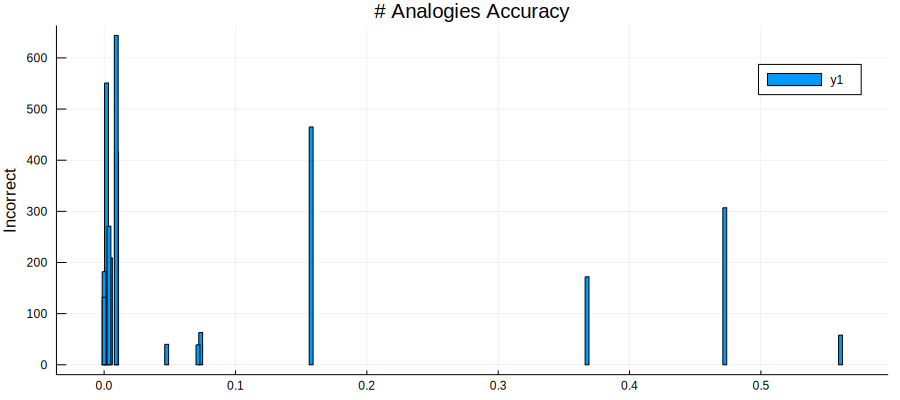

In [87]:
bar(results[:Average], results["Incorrect"])
plot!(size=(900, 400))
ylabel!("Incorrect")
title!("# Analogies Accuracy")

In [78]:
counter = Dict()
open(sentence_path, "r") do file
    for line ∈ readlines(file)
        addcounts!(counter, split(line))
    end
end
counter = sort(collect(counter), by=x->x[2], rev=true)

43285-element Vector{Pair{Any, Any}}:
         "said" => 62486
      "company" => 42908
         "year" => 31432
      "percent" => 31189
          "new" => 30009
      "reuters" => 29705
    "president" => 19066
       "market" => 18433
    "financial" => 18110
     "business" => 18043
      "million" => 17564
        "trump" => 15805
    "including" => 14762
                ⋮
       "donato" => 1
 "unassumingly" => 1
     "grieving" => 1
    "hindrance" => 1
   "culbertson" => 1
       "sahara" => 1
  "calibrating" => 1
    "socialism" => 1
   "shortlived" => 1
    "biovitrum" => 1
    "punctured" => 1
       "paltry" => 1

In [79]:
most_common = DataFrame(token = [pair[1] for pair in counter], count=[pair[2] for pair in counter])
most_common = filter(row -> row.count > MIN_FREQ, most_common)
most_common[!, "p"] = log.(most_common["count"])./sum(log.(most_common["count"]))
most_common

,token,count,p
,SubStri…,Int64,Float64
1,said,62486,0.000252494
2,company,42908,0.000243899
3,year,31432,0.000236783
4,percent,31189,0.000236605
5,new,30009,0.000235723
6,reuters,29705,0.000235491
7,president,19066,0.000225352
8,market,18433,0.00022458
9,financial,18110,0.000224176


In [80]:
similars = DataFrame()
for token in StatsBase.sample(most_common.token, Weights(most_common.p), 10)
    similars[token] = [s[1] for s ∈ model.wv.most_similar(token)]
end
similars_T = DataFrame([[names(similars)]; collect.(eachrow(similars))], [:token; Symbol.(axes(similars, 1))])

,token,1,2,3,4,5,6
,String,String,String,String,String,String,String
1,greater,risk,long,china,compared,increase,placebo
2,tm,actinium,innovative,tumors,clinical,technologies,treat
3,jessica,henning,sandra,gloystein,shounak,contact,shankar
4,cos,kushner,cooperating,disclosure,visas,journal,jared
5,lawyer,court,atilla,orsted,constitutional,vu,comment
6,matters,historical,materially,litigation,actual,herein,differ
7,emma,rican,martin,costa,heather,edward,pilots
8,frequent,supermarkets,extreme,wildfires,warming,flake,trigger
9,realty,trust,properties,estate,reit,nyse,real


In [82]:
mkdir("figures")
CSV.write("figures/most_similar.csv", similars_T[1:5, 1:5])

"figures/most_similar.csv"

## Resources

- [Distributed representations of words and phrases and their compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Efficient estimation of word representations in vector space](https://arxiv.org/pdf/1301.3781.pdf?)
- [Sebastian Ruder"s Blog](http://ruder.io/word-embeddings-1/)